In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/myself/
%ls

Mounted at /content/drive
/content/drive/MyDrive/myself
Data_preprocessing/                 DeepFashion_Try_On_흰옷_최종본.ipynb
DeepFashion_Try_On_최종_제출.ipynb


In [3]:
!git clone https://github.com/kairess/ACGPN.git
%cd ACGPN

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/drive/MyDrive/myself/ACGPN


## Dependencies

In [4]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 4.8 MB/s eta 0:00:00


In [5]:
import gdown
import numpy as np
from PIL import Image
import IPython
import gdown
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [6]:
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [7]:
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
!git clone https://github.com/levindabhi/U-2-Net.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (769/769), done.
remote: Compressing objects: 100% (583/583), done.
remote: Total 769 (delta 184), reused 661 (delta 175), pack-reused 0
Receiving objects: 100% (769/769), 3.89 MiB | 12.81 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Updating files: 100% (546/546), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (439/439), done.
remote: Total 822 (delta 389), reused 793 (delta 379), pack-reused 0
Receiving objects: 100% (822/822), 30.71 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (389/389), done.
Updating files: 100% (173/173), done.


## 사전학습 모델 다운로드

### 포즈 예측 모델

In [8]:
#에러난 부분

!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko 



### 휴먼 세그멘테이션 마스크 생성 모델

In [9]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=55cbecc0-8801-40ff-a7f1-344484d9aade
To: /content/drive/MyDrive/myself/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:01<00:00, 146MB/s]


'lip_final.pth'

### U2Net 모델

옷 마스크 추출 모델

In [10]:
%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd ..

/content/drive/MyDrive/myself/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/drive/MyDrive/myself/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 151MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=d6e843e8-01a9-4194-90c7-838526213791
To: /content/drive/MyDrive/myself/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:00<00:00, 293MB/s]
...load U2NEP---4.7 MB
/content/drive/MyDrive/myself/ACGPN


### ACGPN 모델

In [11]:
!mkdir checkpoints

gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
From (redirected): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx&confirm=t&uuid=6831fd99-5688-4102-9d14-ced6b3b0c228
To: /content/drive/MyDrive/myself/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:02<00:00, 224MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


## 전처리

### 옷 마스크 추출

In [13]:
sorted(os.listdir('change/all'))

['000010_1.jpg',
 '000020_1.jpg',
 '000028_1.jpg',
 '000038_1.jpg',
 '000048_1.jpg',
 '000057_1.jpg',
 '000066_1.jpg',
 '000074_1.jpg',
 '000082_1.jpg',
 '000097_1.jpg',
 '000109_1.jpg',
 '000118_1.jpg',
 '000129_1.jpg',
 '000143_1.jpg',
 '000154_1.jpg',
 '000164_1.jpg',
 '000386_1.jpg',
 '000404_1.jpg',
 '000456_1.jpg',
 '000466_1.jpg',
 '000514_1.jpg',
 '000696_1.jpg',
 '000750_1.jpg']

In [15]:
#방법1

#흰옷 저장하는 것
# cloth_name = f'cloth_{int(time.time())}.png'
from glob import glob

cloth_path = glob("change/all/*")
print(cloth_path)
# cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth')))
for path in cloth_path:
  print(path)
  cloth = Image.open(path)
  cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')

  center_y = 96
  center_x = 128

  cloth_arr = np.array(cloth)
  if np.mean(cloth_arr[center_y, center_x]) >= 220: # white cloth
    img_name = path.split('/')[-1]
  
    cloth.save('change/white/'+img_name)


# cloth = Image.open(cloth_path)
# cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
# cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

# Image.open(f'Data_preprocessing/test_edge/{img_name}')

['change/all/000020_1.jpg', 'change/all/000010_1.jpg', 'change/all/000074_1.jpg', 'change/all/000057_1.jpg', 'change/all/000028_1.jpg', 'change/all/000038_1.jpg', 'change/all/000048_1.jpg', 'change/all/000164_1.jpg', 'change/all/000066_1.jpg', 'change/all/000143_1.jpg', 'change/all/000129_1.jpg', 'change/all/000082_1.jpg', 'change/all/000109_1.jpg', 'change/all/000118_1.jpg', 'change/all/000097_1.jpg', 'change/all/000154_1.jpg', 'change/all/000386_1.jpg', 'change/all/000404_1.jpg', 'change/all/000456_1.jpg', 'change/all/000514_1.jpg', 'change/all/000696_1.jpg', 'change/all/000466_1.jpg', 'change/all/000750_1.jpg']
change/all/000020_1.jpg
change/all/000010_1.jpg
change/all/000074_1.jpg
change/all/000057_1.jpg
change/all/000028_1.jpg
change/all/000038_1.jpg
change/all/000048_1.jpg
change/all/000164_1.jpg
change/all/000066_1.jpg
change/all/000143_1.jpg
change/all/000129_1.jpg
change/all/000082_1.jpg
change/all/000109_1.jpg
change/all/000118_1.jpg
change/all/000097_1.jpg
change/all/000154_

In [16]:
#white에 있는 옷중에 골라서 cloth 파일에 넣었음

sorted(os.listdir('inputs/cloth'))

['000020_1.jpg']

### 모델 포즈, 세그멘테이션

In [28]:
sorted(os.listdir('inputs/img'))

['000001_0.jpg']

In [57]:

#방법2

#전체 색깔의 평균내기 2분에 1 이상 240값이 차지하고 있다면 흰옷으로 치는 것!

img_name = f'img_{int(time.time())}.png'
from glob import glob
data = glob('change/all/*')


for i in data:
  img = Image.open(i)
  img = img.resize((192, 256),Image.BICUBIC)
  checker = np.array(img)

  len_white = np.where(( (checker[i][0]+checker[i][1]+ checker[i][2]) / 3)>=200)

  if len(len_white[0]) > (192*256)/2:
    save_path = i.split('/')[-1]
    img.save('change/white2/'+save_path)


In [25]:

img_name = f'img_{int(time.time())}.png'

img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])
img = Image.open(img_path)
img = img.resize((192,256), Image.BICUBIC)

img_path = os.path.join('Data_preprocessing/test_img', img_name)
img.save(img_path)

!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))
generate_pose_keypoints(img_path, pose_path)

'''
img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])
img = Image.open(img_path)
img = img.resize((192,256), Image.BICUBIC)
#img = np.array(img)

img_path = os.path.join('Data_preprocessing/test_img', img_name)
img.save(img_path)

!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))
generate_pose_keypoints(img_path, pose_path) '''

#직접 다운로드 해야함 사이트 들어가서

100% 28/28 [00:03<00:00,  8.81it/s]


error: ignored

## 추론

In [ ]:
#cloth_name은 어떠한 옷을 적용할 것인지 옷 파일 명을 적어야함(확장자 포함)
img_name = '000001_0.jpg'
cloth_name = '000020_1.jpg'
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
  f.write(f'{img_name} {cloth_name}')
!pwd

/content/drive/MyDrive/ai/ACGPN


In [ ]:
!python test.py

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

## 결과

/content/drive/MyDrive/ai/ACGPN


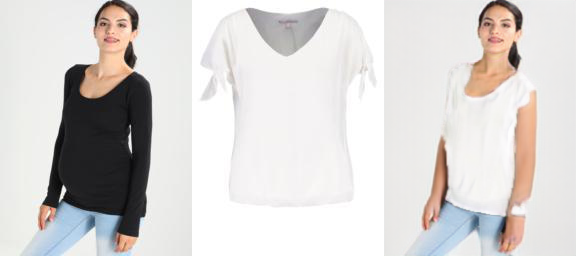

In [ ]:
!pwd
output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/img_1685346004.png'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid